<a href="https://colab.research.google.com/github/OnkarS13/CVProjects/blob/main/Onion_Detection_and_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio
!pip install 'git+https://github.com/facebookresearch/detectron2.git' --user

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-y58ane4n
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-y58ane4n
  Resolved https://github.com/facebookresearch/detectron2.git to commit e70b9229d77aa39d85f8fa5266e6ea658e92eed3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6120365 sha256=ac3c70ce0bd46fef6f7226c7b3503

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2 import model_zoo

from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt

def plot_samples(dataset_name, n = 1):
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)

    for s in random.sample(dataset_custom, n):
        img = cv2.imread(s["file_name"])
        v = Visualizer(img[:, :, ::-1], metadata = dataset_custom_metadata, scale = 0.5)
        v = v.draw_dataset_dict(s)
        plt.figure(figsize = (15, 20))
        plt.imshow(v.get_image())
        plt.show()



def get_train_cfg(config_file_path, checkpoint_url, train_dataset_name, test_dataset_name, num_classes, device, output_dir):
    cfg = get_cfg()

    cfg.merge_from_file(model_zoo.get_config_file(config_file_path))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = (test_dataset_name,)

    cfg.DATALOADER.NUM_WORKERS = 2

    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 1000
    cfg.SOLVER.STEPS = []

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.MODEL.DEVICE = device
    cfg.OUTPUT_DIR = output_dir

    return cfg


def on_image(image_path, predictor):
    im = cv2.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], metadata = {}, scale = 0.5, instance_mode = ColorMode.SEGMENTATION)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize = (14, 10))
    plt.imshow(v.get_image())
    plt.show()


In [6]:
# TRAIN

from detectron2.utils.logger import setup_logger

setup_logger()

from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

import os
import pickle

# from utils import *

config_file_path = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

output_dir = "./output/instance_segmentation"
num_classes = 3

device = "cuda"

train_dataset_name = "IS_train"
train_images_path = "/content/drive/MyDrive/DataSets/Onion Dataset/train"
train_json_annot_path = "/content/drive/MyDrive/DataSets/Onion Dataset/train.json"


test_dataset_name = "IS_test"
test_images_path = "/content/drive/MyDrive/DataSets/Onion Dataset/test"
test_json_annot_path = "/content/drive/MyDrive/DataSets/Onion Dataset/test.json"

cfg_save_path = "IS_cfg.pickle"

############################################################

register_coco_instances(name = train_dataset_name,
                        metadata = {},
                        json_file = train_json_annot_path,
                        image_root = train_images_path)

register_coco_instances(name = test_dataset_name,
                        metadata = {},
                        json_file = test_json_annot_path,
                        image_root = test_images_path)


# plot_samples(dataset_name = train_dataset_name, n = 2)

def main():
    cfg = get_train_cfg(config_file_path, checkpoint_url, train_dataset_name, test_dataset_name, num_classes, device, output_dir)

    with open(cfg_save_path, 'wb') as f:
        pickle.dump(cfg, f, protocol = pickle.HIGHEST_PROTOCOL)

    os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)

    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume = False)

    trainer.train()



In [7]:
if __name__ == '__main__':
    main()

[02/07 13:18:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 190MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[02/07 13:18:43 d2.engine.train_loop]: Starting training from iteration 0
[02/07 13:18:55 d2.utils.events]:  eta: 0:08:41  iter: 19  total_loss: 2.554  loss_cls: 1.431  loss_box_reg: 0.3193  loss_mask: 0.6881  loss_rpn_cls: 0.05773  loss_rpn_loc: 0.02634    time: 0.5258  last_time: 0.5902  data_time: 0.0627  last_data_time: 0.0085   lr: 4.9953e-06  max_mem: 2404M
[02/07 13:19:06 d2.utils.events]:  eta: 0:08:34  iter: 39  total_loss: 2.359  loss_cls: 1.28  loss_box_reg: 0.3029  loss_mask: 0.6828  loss_rpn_cls: 0.04499  loss_rpn_loc: 0.01619    time: 0.5290  last_time: 0.4541  data_time: 0.0127  last_data_time: 0.0066   lr: 9.9902e-06  max_mem: 2405M
[02/07 13:19:17 d2.utils.events]:  eta: 0:08:31  iter: 59  total_loss: 2.143  loss_cls: 1.007  loss_box_reg: 0.3287  loss_mask: 0.6753  loss_rpn_cls: 0.03787  loss_rpn_loc: 0.02286    time: 0.5369  last_time: 0.6394  data_time: 0.0147  last_data_time: 0.0281   lr: 1.4985e-05  max_mem: 2405M
[02/07 13:19:28 d2.utils.events]:  eta: 0:08:25  it

[02/07 13:34:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/instance_segmentation/model_final.pth ...


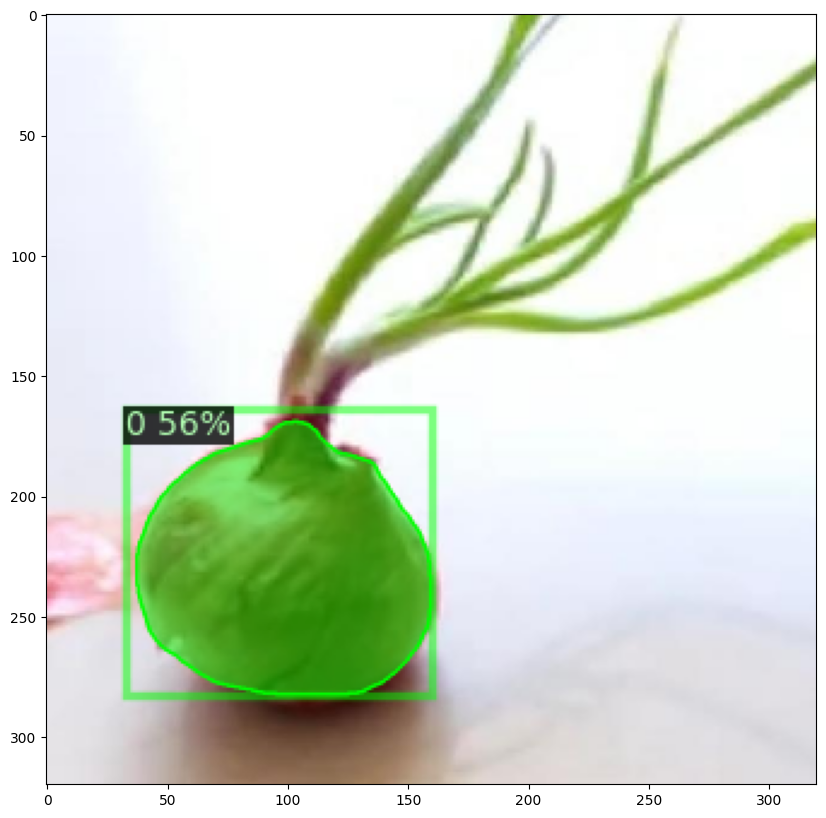

In [11]:
# TEST

from detectron2.engine import DefaultPredictor
import os
import pickle
# from utils import *

cfg_save_path = "IS_cfg.pickle"

with open(cfg_save_path, 'rb') as f:
    cfg = pickle.load(f)

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

predictor = DefaultPredictor(cfg)

image_path = "/content/drive/MyDrive/DataSets/Onion Dataset/test/img_tr75_png_jpg.rf.87cc97dac2e3eecc1167ff3ad5151a96.jpg"

on_image(image_path, predictor)